# Components with hierarchy

![](https://i.imgur.com/3pczkyM.png)

You can define component parametric cells (waveguides, bends, couplers) as functions with basic input parameters (width, length, radius ...) and use them as arguments for composing more complex functions.

In [1]:
from functools import partial

import toolz

import gdsfactory as gf
from gdsfactory.typings import ComponentSpec, CrossSectionSpec

**Problem**

When using hierarchical cells where you pass `N` subcells with `M` parameters you can end up with `N*M` parameters. This is make code hard to read.


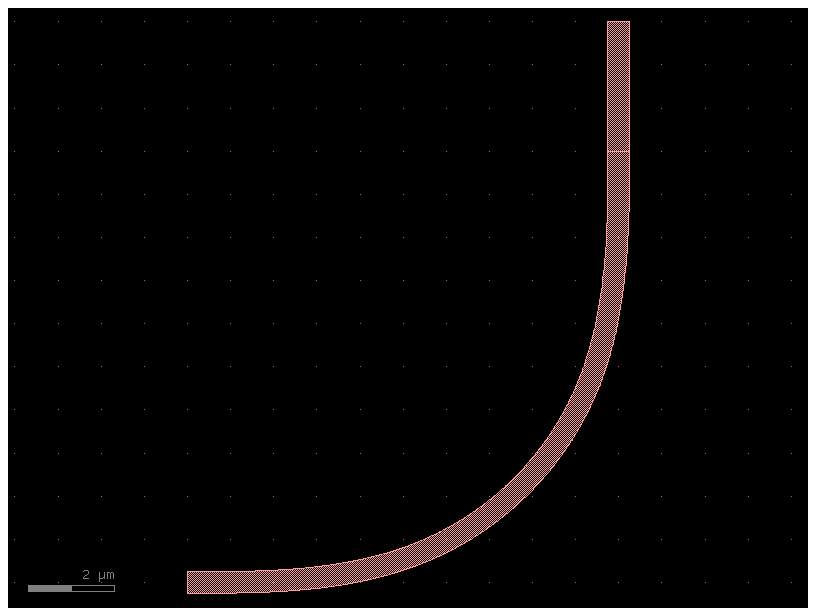

In [2]:
@gf.cell
def bend_with_straight_with_too_many_input_parameters(
    bend=gf.components.bend_euler,
    straight=gf.components.straight,
    length: float = 3,
    angle: float = 90.0,
    p: float = 0.5,
    with_arc_floorplan: bool = True,
    npoints: int | None = None,
    cross_section: CrossSectionSpec = "strip",
) -> gf.Component:
    """As hierarchical cells become more complex, the number of input parameters can increase significantly."""
    c = gf.Component()
    b = bend(
        angle=angle,
        p=p,
        with_arc_floorplan=with_arc_floorplan,
        npoints=npoints,
        cross_section=cross_section,
    )
    s = straight(length=length, cross_section=cross_section)

    bref = c << b
    sref = c << s

    sref.connect("o2", bref.ports["o2"])
    c.info["length"] = b.info["length"] + s.info["length"]
    return c


c = bend_with_straight_with_too_many_input_parameters()
c.plot()

**Solution**

You can use a ComponentSpec parameter for every subcell. The ComponentSpec can be a dictionary with arbitrary number of settings, a string, or a function.

## ComponentSpec

When defining a `Parametric cell` you can use other `ComponentSpec` as an arguments. It can be a:

1. string: function name of a cell registered on the active PDK. `"bend_circular"`
2. dict: `dict(component='bend_circular', settings=dict(radius=20))`
3. function: Using `functools.partial` you can customize the default parameters of a function.


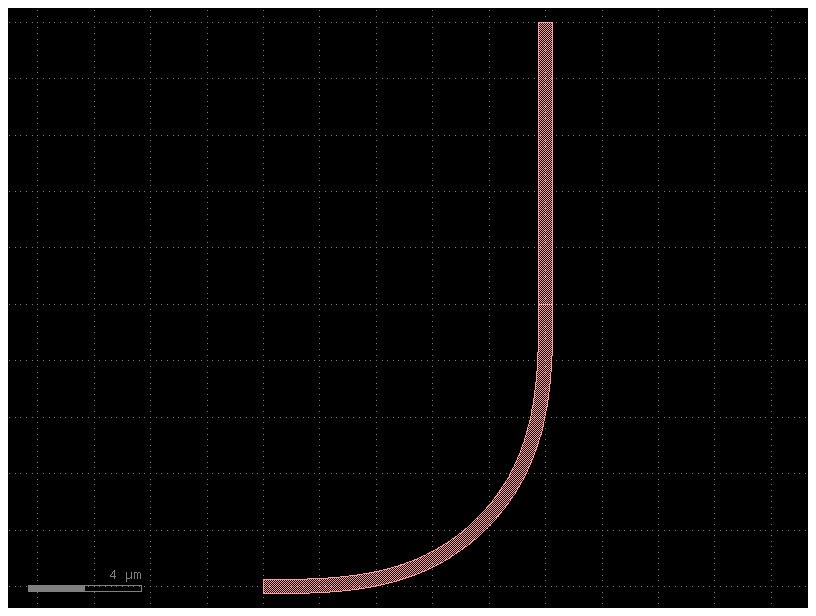

In [3]:
@gf.cell
def bend_with_straight(
    bend: ComponentSpec = gf.components.bend_euler,
    straight: ComponentSpec = gf.components.straight,
) -> gf.Component:
    """Much simpler version.

    Args:
        bend: input bend.
        straight: output straight.
    """
    c = gf.Component()
    b = gf.get_component(bend)
    s = gf.get_component(straight)

    bref = c << b
    sref = c << s

    sref.connect("o2", bref.ports["o2"])
    c.info["length"] = b.info["length"] + s.info["length"]
    return c


c = bend_with_straight()
c.plot()

### 1. string

You can use any string registered in the `Pdk`. Go to the PDK tutorial to learn how to register cells in a PDK.

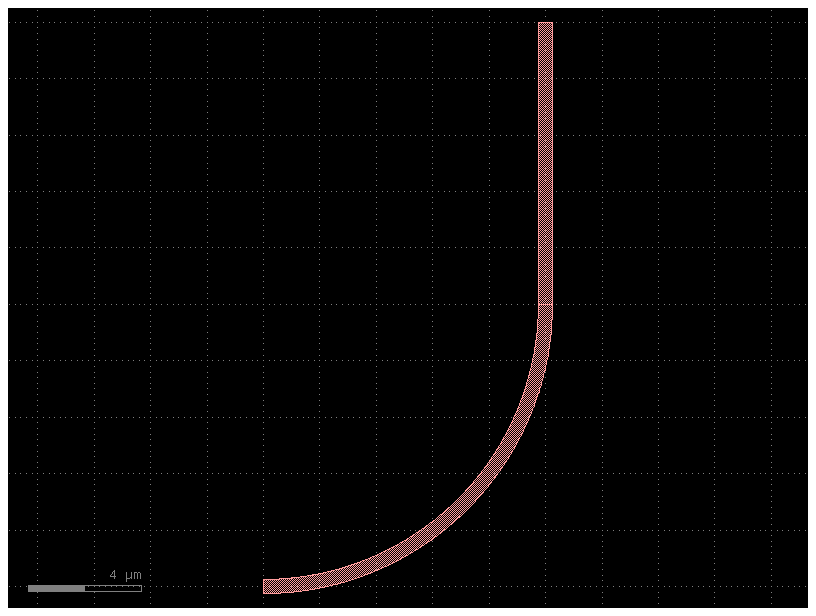

In [4]:
c = bend_with_straight(bend="bend_circular")
c.plot()

### 2. dict

You can pass a dict of settings.

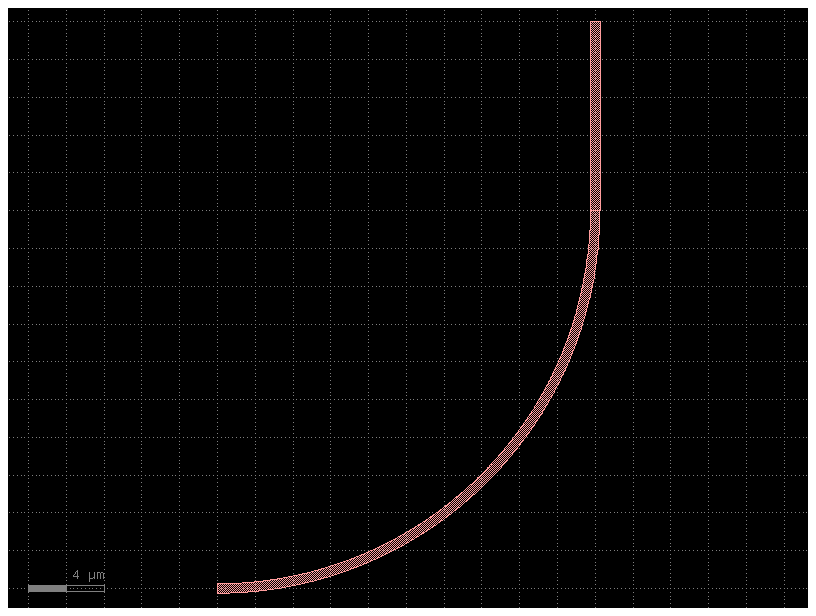

In [5]:
bend = gf.get_component("bend_circular", radius=20)

c = bend_with_straight(bend=bend)
c.plot()

### 3. function

You can pass a function of a function with customized default input parameters `from functools import partial`

Partial lets you define different default parameters for a function, so you can modify the default settings for each child cell.

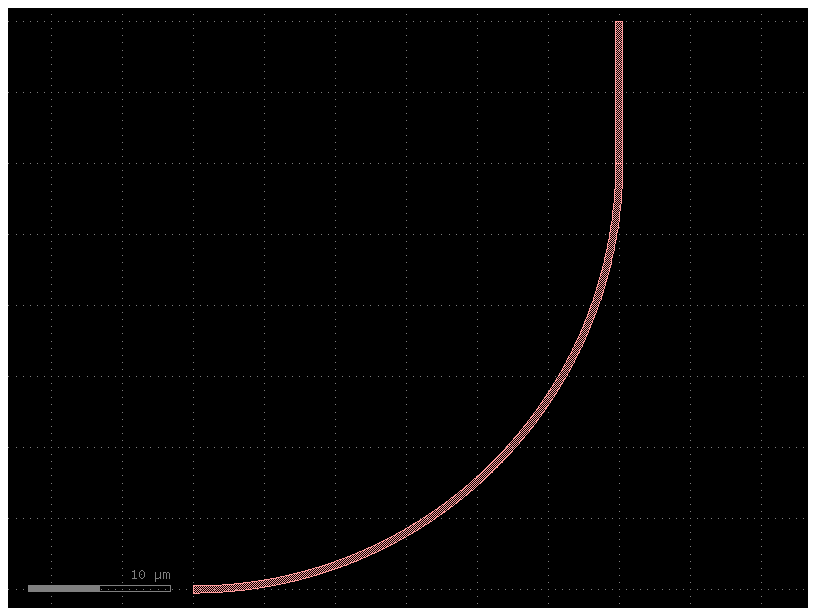

In [6]:
c = bend_with_straight(bend=partial(gf.components.bend_circular, radius=30))
c.plot()

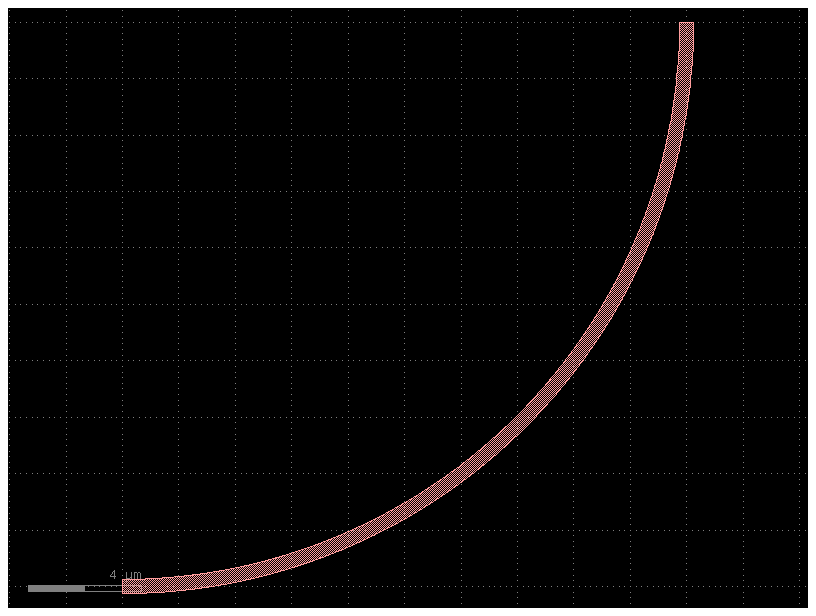

In [7]:
bend20 = partial(gf.components.bend_circular, radius=20)
b = bend20()
b.plot()

In [8]:
type(bend20)

functools.partial

In [9]:
bend20.func.__name__

'bend_circular'

In [10]:
bend20.keywords

{'radius': 20}

41.416


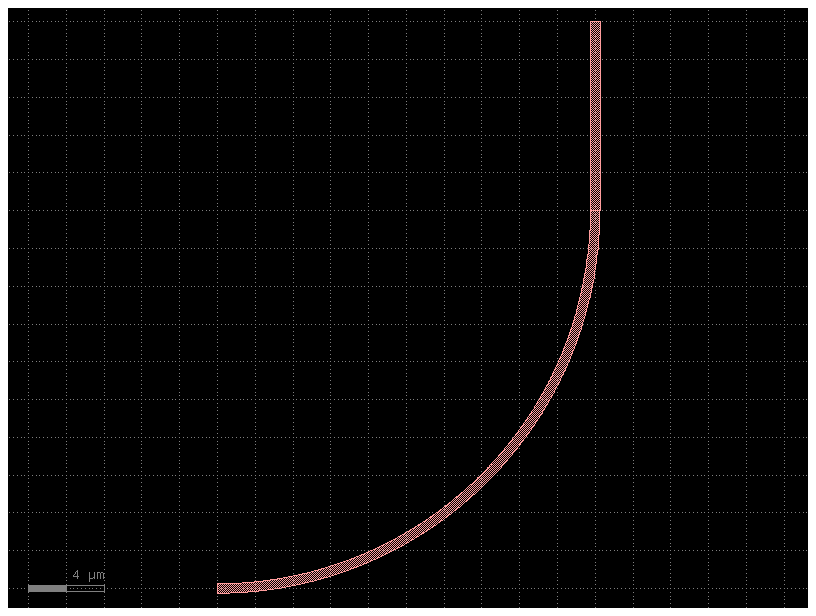

In [11]:
b = bend_with_straight(bend=bend20)
print(b.info.length)
b.plot()

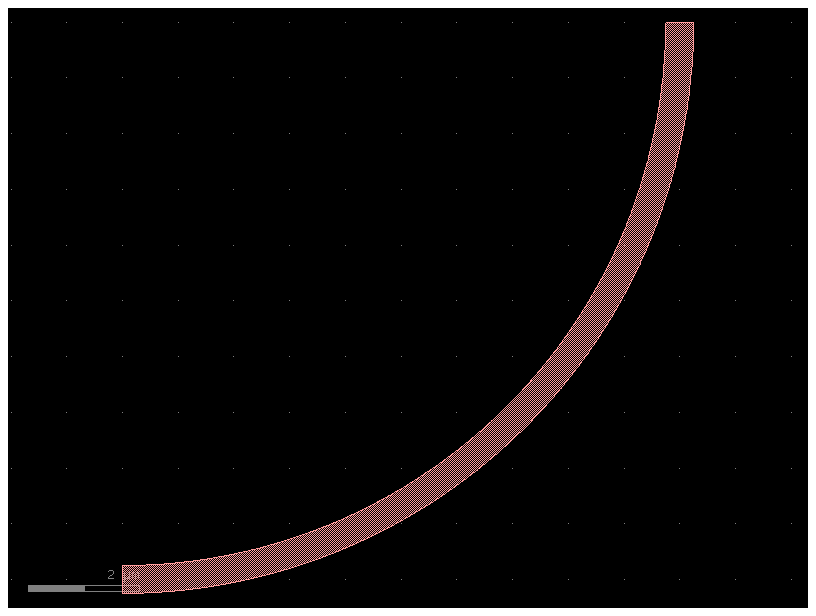

In [12]:
# You can still modify the bend to have any bend radius
b3 = bend20(radius=10)
b3.plot()

## Composing functions

You can combine more complex functions out of smaller functions.

Lets say that we want to add tapers and grating couplers to a wide waveguide.

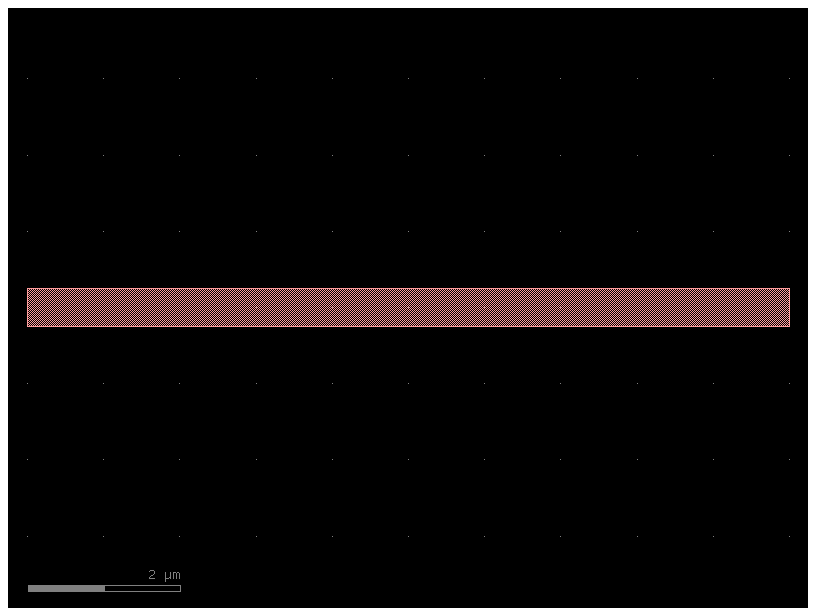

In [13]:
c1 = gf.components.straight()
c1.plot()

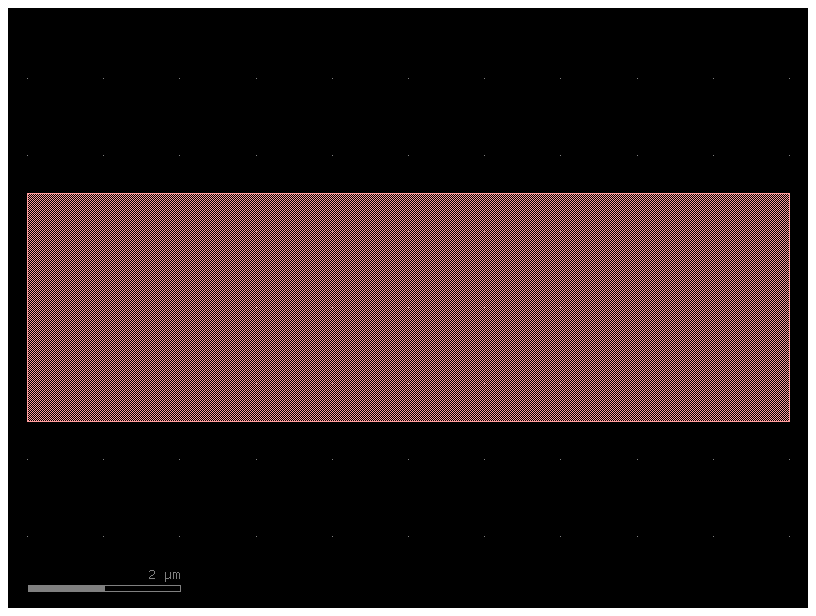

In [14]:
straight_wide = partial(gf.components.straight, width=3)
c3 = straight_wide()
c3.plot()

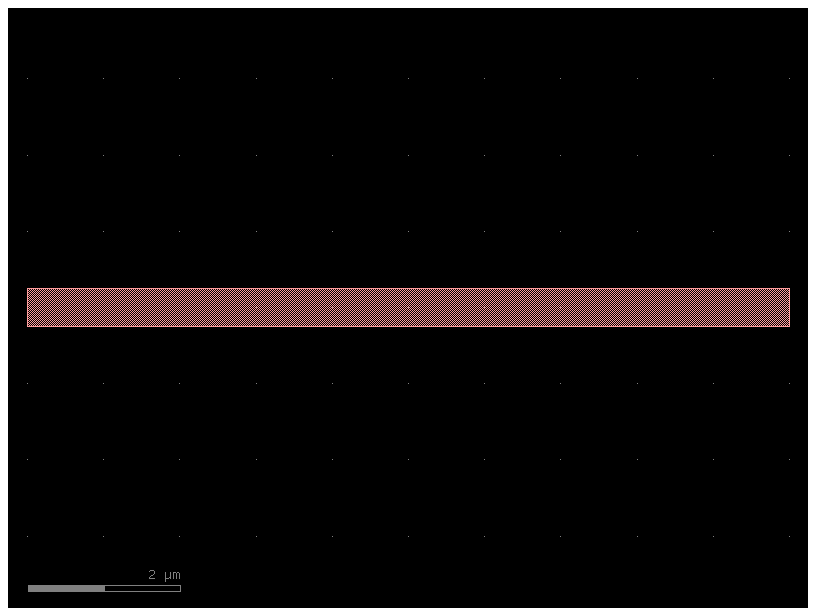

In [15]:
c1 = gf.components.straight()
c1.plot()

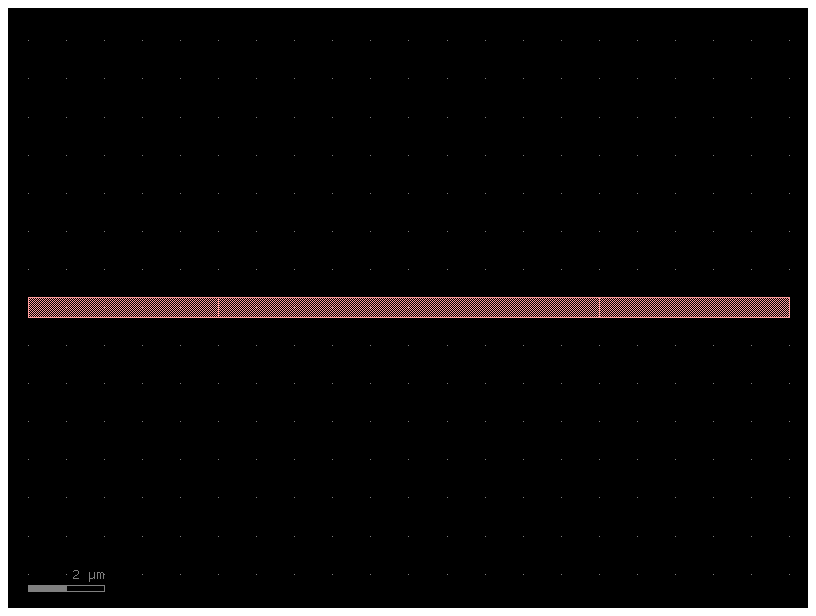

In [16]:
c2 = gf.c.extend_ports(c1, length=5)
c2

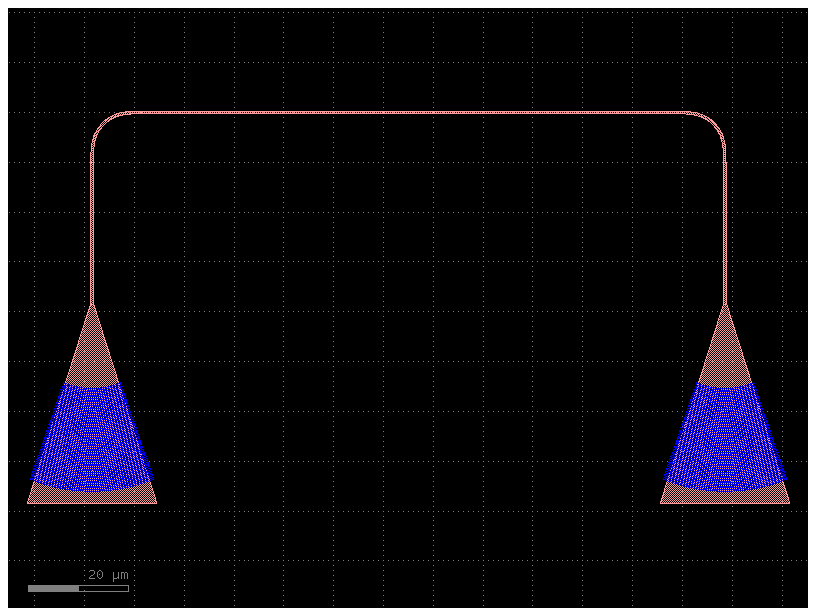

In [17]:
c3 = gf.routing.add_fiber_array(c2, with_loopback=False)
c3.plot()

Lets do it with a **single** step thanks to `toolz.pipe`

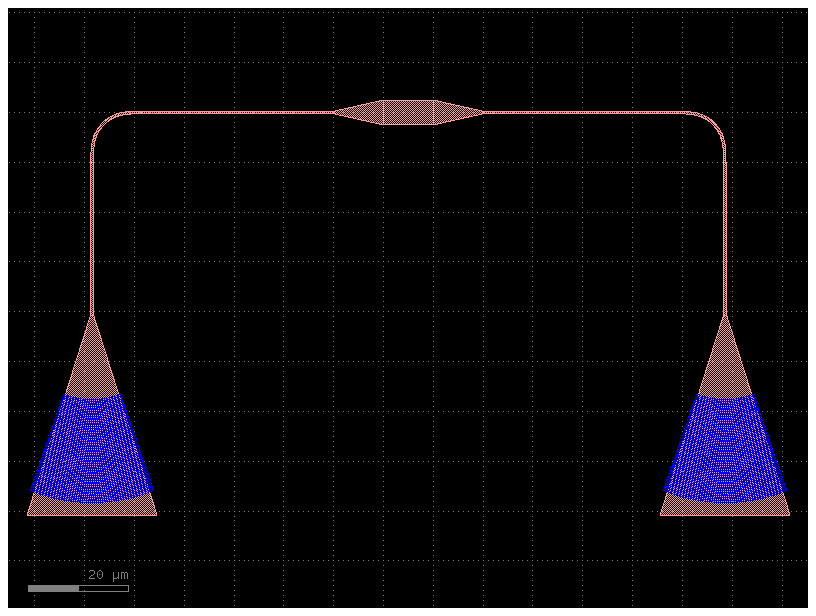

In [18]:
add_fiber_array = partial(gf.routing.add_fiber_array, with_loopback=False)

c1 = gf.c.straight(width=5)
taper = gf.components.taper(length=10, width1=5, width2=0.5)
add_tapers = partial(gf.c.extend_ports, extension=taper)

# pipe is more readable than the equivalent add_fiber_array(add_tapers(c1))
c3 = toolz.pipe(c1, add_tapers, add_fiber_array)
c3.plot()

we can even combine `add_tapers` and `add_fiber_array` thanks to `toolz.compose` or `toolz.compose`

For example:

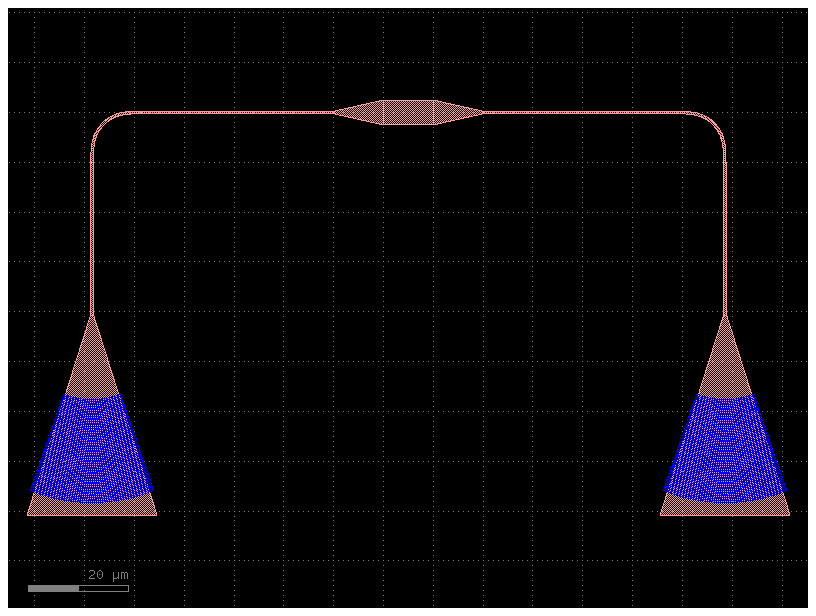

In [19]:
add_tapers_fiber_array = toolz.compose_left(add_tapers, add_fiber_array)
c4 = add_tapers_fiber_array(c1)
c4.plot()

is equivalent to

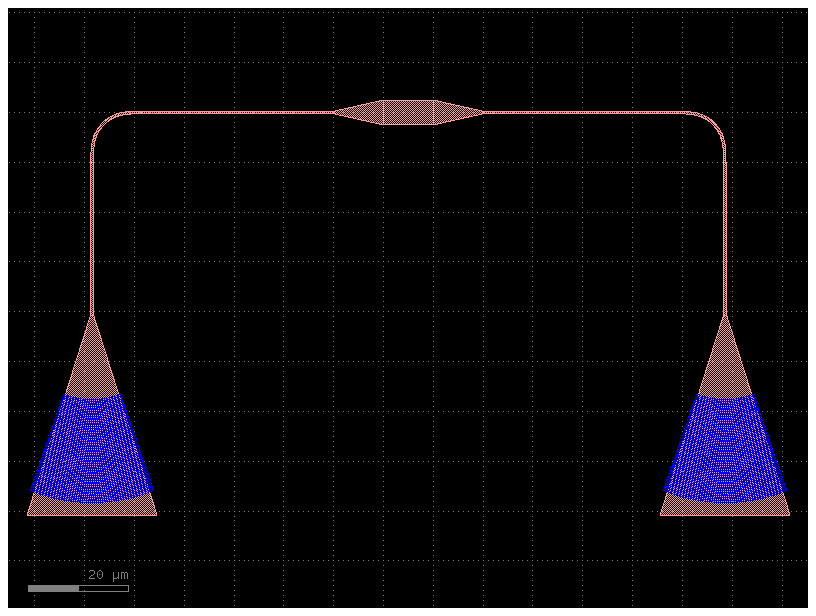

In [20]:
c5 = add_fiber_array(add_tapers(c1))
c5.plot()

as well as equivalent to

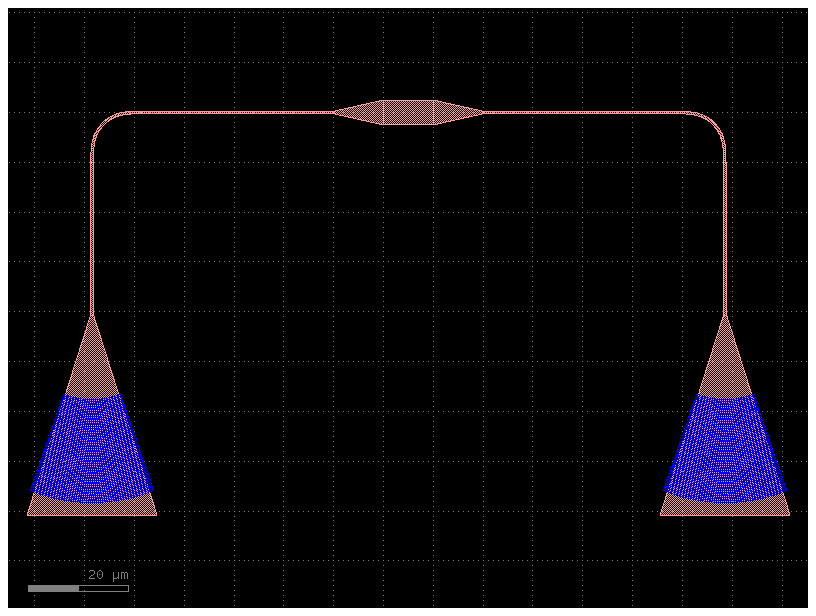

In [21]:
add_tapers_fiber_array = toolz.compose(add_fiber_array, add_tapers)
c6 = add_tapers_fiber_array(c1)
c6.plot()

or

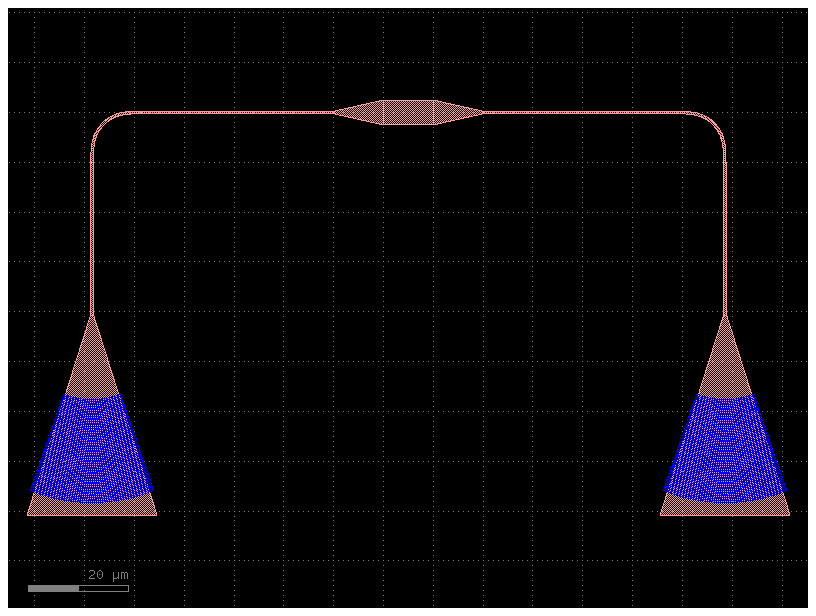

In [22]:
c7 = toolz.pipe(c1, add_tapers, add_fiber_array)
c7.plot()